In [1]:
# IMPORTS
import pandas as pd
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import KFold
import razdel
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
# удобное переименование и импорт даты
def relabel(sample): 
    if sample == '_':
        return 'O'
    if sample.startswith('патологический'):
        return 'PAT'
    if sample.startswith('физиологический '):
        return 'PHY'
    
data = pd.read_csv('data/parsed/task_parsed.txt', sep='\t', header=None)
data = data[[2,3,7]].rename(columns={2 : 'text', 3 : 'label', 7 : 'task'})
data['label'] = data['label'].map(lambda x: relabel(x))
data

,text,label,task
0,СЗ_Лечебное,O,270
1,дело,O,270
2,(,O,270
3,ч,O,270
4,.4,O,270
...,...,...,...
12272,обязательными,O,314
12273,для,O,314
12274,данного,O,314
12275,заболевания,O,314


In [3]:
# Правильное разбиение на предложения
def sentenizer(words, tags, tasks):
    out_texts = []
    out_tags = []
    out_tasks = []
    splitted = []
    tag = []
    cur_word = 0
    text = ''
    for i in words:
        text += i + ' '
    
    text = list(razdel.sentenize(text))
    
    for i in text:
        i = i.text.split()
        tag = list(tags[cur_word:cur_word + len(i)])
        task = tasks[cur_word + len(i)-1]
        cur_word += len(i)
        
        out_texts.append(i)
        out_tags.append(tag)
        out_tasks.append(task)
        
    return out_texts, out_tags, out_tasks

texts, tags, tasks = sentenizer(data['text'],data['label'],data['task'])
ner = pd.DataFrame({
    'words' : texts,
    'ner' : tags,
    'task' : tasks
})

In [4]:
# добавляем тег START
def span_start(ner):
    out = []
    cache = ner[1]
    for i,item in enumerate(ner):
        
        if i == 0 and item in ['PHY', 'PAT']:
            out.append(item+'-START')
            cache = item
            continue
        
        if item in ['PHY', 'PAT'] and cache != item:
            out.append(item+'-START')
            cache = item
        else:
            out.append(item)
            cache = item
            
    return out

ner.ner = ner.ner.map(lambda x: span_start(x))

Text(0.5, 0, 'Task')

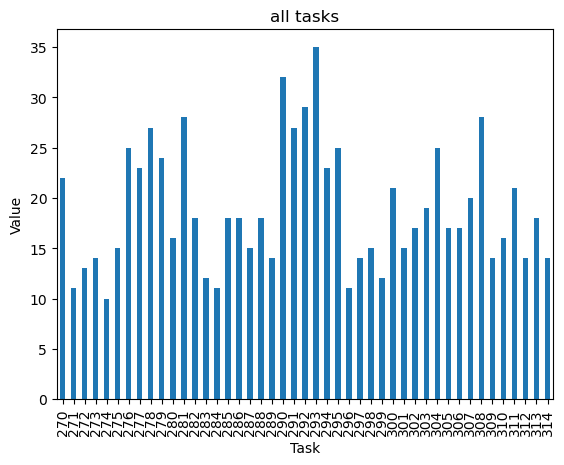

In [6]:
ax = ner.task.value_counts().sort_index().plot(kind = 'bar', title = 'all tasks')
ax.set_ylabel("Count")
ax.set_xlabel("Task")

In [1]:
# разбиваем на фолды
fold_train = []
fold_test = []
X = ner.drop(columns=['task'])
y = ner['task']
skf = StratifiedGroupKFold(n_splits=5, shuffle= True, random_state=15) # StratifiedGroupKFold
for i, (train_index, test_index) in enumerate(skf.split(X, y, y)):
    ner.iloc[train_index].to_csv('data/ner/newtrainfold_' + str(i) + '.csv') # сделать json
    ner.iloc[test_index].to_csv('data/ner/newtestfold_' + str(i) + '.csv') # сделать json
    fold_train.append(ner.iloc[train_index])
    fold_test.append(ner.iloc[test_index])

NameError: name 'ner' is not defined

In [9]:
# свой value_counts
def alloc (fold):
    ner = {'O' : 0, 'PHY' : 0, 'PAT' : 0}
    ner_perc = {'O' : 0, 'PHY' : 0, 'PAT' : 0}
    count = 0
    
    for i in fold.ner:
        for j in i:
            
            if j == 'O':
                ner['O'] += 1
                count += 1
                
            if j == 'PHY':
                ner['PHY'] += 1
                count += 1
                
            if j == 'PAT':
                ner['PAT'] += 1
                count += 1
                
    ner_perc['O'] = ner['O']/count
    ner_perc['PHY'] = ner['PHY']/count
    ner_perc['PAT'] = ner['PAT']/count
    
    return ner, ner_perc

In [10]:
# распределение
def devination (folds):
    O = 0
    PHY = 0
    PAT = 0
    ner = {'O' : [], 'PHY' : [], 'PAT' : []}
    
    for i in range(5):
        metrics = alloc(folds[i])[1]
        
        ner['O'].append(metrics['O'])
        ner['PHY'].append(metrics['PHY'])
        ner['PAT'].append(metrics['PAT'])
        
        
        O += metrics['O']
        PHY += metrics['PHY']
        PAT += metrics['PAT']
        
    return {'O' : O/5, 'PHY' : PHY/5, 'PAT' : PAT/5}, {'O' : np.std(ner['O']), 'PHY' : np.std(ner['PHY']), 'PAT' : np.std(ner['PAT'])}

In [11]:
# среднее и CO по фолдам
temp = devination(fold_train)
print ('ALL FOLDS:')
print ('mean - ' + str(temp[0]))
print ('std - ' + str(temp[1]))

ALL FOLDS:
mean - {'O': 0.6723870142944817, 'PHY': 0.08624494884044297, 'PAT': 0.2413680368650754}
std - {'O': 0.0066781831362363354, 'PHY': 0.004028156205041189, 'PAT': 0.004825014454797389}


In [12]:
# соотношения классов в долях
print ('PERCENTAGE:')
for i in range(5):
    print ('fold ' + str (i) + ' - ' + str(alloc(fold_train[i])[1]))

PERCENTAGE:
fold 0 - {'O': 0.6660141381185427, 'PHY': 0.09342033713974987, 'PAT': 0.24056552474170745}
fold 1 - {'O': 0.6643249176728869, 'PHY': 0.08693743139407245, 'PAT': 0.24873765093304062}
fold 2 - {'O': 0.671562082777036, 'PHY': 0.08400089007565643, 'PAT': 0.24443702714730753}
fold 3 - {'O': 0.6803822372119168, 'PHY': 0.08139404159640247, 'PAT': 0.23822372119168073}
fold 4 - {'O': 0.6796516956920257, 'PHY': 0.08547204399633364, 'PAT': 0.2348762603116407}


In [13]:
print('COUNT:')
for i in range(5):
    print ('fold ' + str (i) + ' - ' + str(alloc(fold_train[i])[0]))

COUNT:
fold 0 - {'O': 6124, 'PHY': 859, 'PAT': 2212}
fold 1 - {'O': 6052, 'PHY': 792, 'PAT': 2266}
fold 2 - {'O': 6036, 'PHY': 755, 'PAT': 2197}
fold 3 - {'O': 6052, 'PHY': 724, 'PAT': 2119}
fold 4 - {'O': 5932, 'PHY': 746, 'PAT': 2050}


all tasks count - 686
mean - 19.055555555555557
count - 36


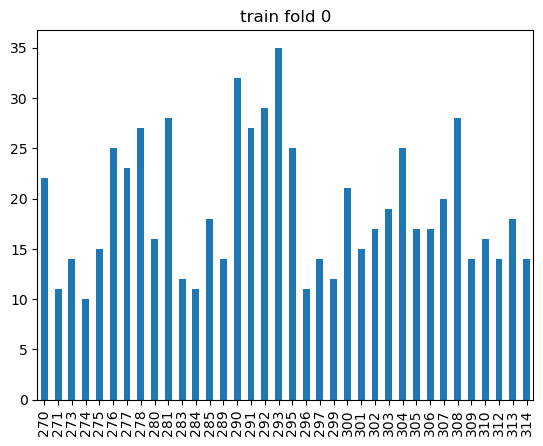

In [14]:
fold_train[0].task.value_counts().sort_index().plot(kind='bar', title = 'train fold 0')
print('all tasks count - ' +  str(len(fold_train[0])))
print('mean - ' + str(fold_train[0].task.value_counts().mean()))
print('count - ' + str(len(fold_train[0].task.value_counts()))) # по таргету в процентах физ и пат

all tasks count - 165
mean - 18.333333333333332
count - 9


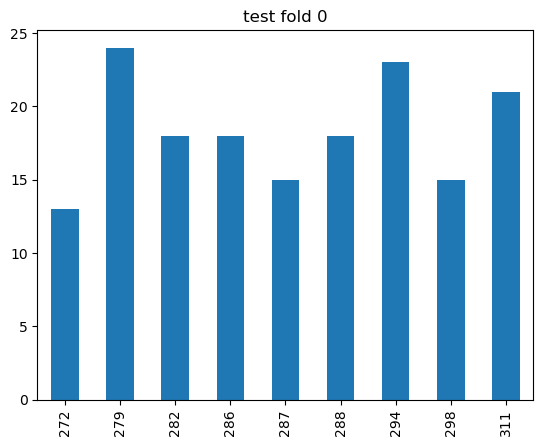

In [15]:
fold_test[0].task.value_counts().sort_index().plot(kind='bar', title = 'test fold 0')
print('all tasks count - ' + str(len(fold_test[0])))
print('mean - ' + str(fold_test[0].task.value_counts().mean()))
print('count - ' + str(len(fold_test[0].task.value_counts())))